Exercise Sheet 4 **Saliency**

__Adu Matory__ and __Lukas Braun__, November 8, 2019

In [0]:
import numpy as np
# import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.colors as colo
import scipy.ndimage as ndi

**Exercise 1: Saliency Maps from Local Standard Deviation**

1. Pick one of the provided color images (salience.zip) and import it as a 3D-array
(99x150x3 entries) using e.g. matplotlib.pyplot.imread or scipy.misc.imread.
The third dimension represents the three colors red, green and blue. **Plot the color
image as well as the three channels separately as a gray level image into a single
figure.** You may notice that the information between the color channels is highly
redundant. 

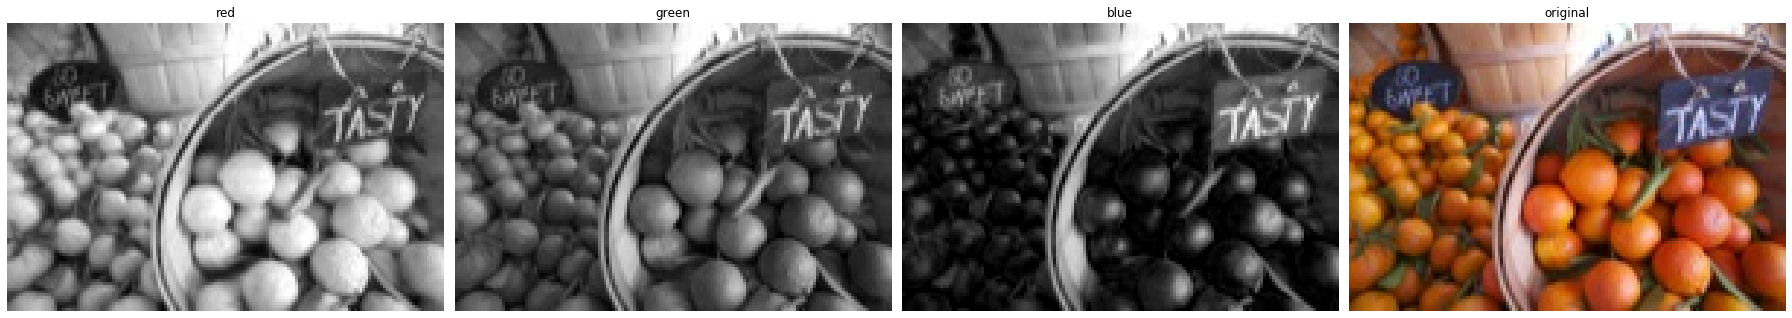

In [0]:
img = plt.imread('salience/salience_19.png')
colors = ['red','green','blue','original']


def imgplot(imag,chan):
  f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4)

  f.set_figheight(10)
  f.set_figwidth(15)

  ax1.imshow(imag[:,:,0],cmap='gray')
  ax2.imshow(imag[:,:,1],cmap='gray')
  ax3.imshow(imag[:,:,2],cmap='gray')
  ax4.imshow(imag)

  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')

  ax1.set_title(chan[0])
  ax2.set_title(chan[1])
  ax3.set_title(chan[2])
  ax4.set_title(chan[3])

  plt.tight_layout()

imgplot(img,colors)

To quantify the redundancy, **compute the three pairwise correlation
coefficients between each of the three color channels across all pixels (hint: use the
function flatten to convert each image channel into a vector, stack those vectors
into a matrix and then apply numpy.corrcoef to obtain all pairwise correlation
coefficients).**


In [0]:
def chanCorr(imag):
  vecimgs = []
  imgs = [imag[:,:,0],imag[:,:,1],imag[:,:,2]]

  for i,x in enumerate(imgs):
    vecimgs.append(np.reshape(x,x.size))

  matimgs = np.vstack(vecimgs)
  print(np.corrcoef(matimgs))

chanCorr(img)

[[1.         0.8076609  0.45894387]
 [0.8076609  1.         0.84870406]
 [0.45894387 0.84870406 1.        ]]


**Is there anything striking in the correlations? Why is this not surprising given the way natural images arise (hint: think about what determines the
content of a photograph of a natural scene)?**

The red-green and blue-green correlations are quite high, especially in comparison to the red-blue correlation. This is not surprising given red and blue lie on opposite ends of the color spectrum and a natural scene's color follow log-power laws. This means we'll have more red (lower frequency wavelength) and less blue (higher frequency) in an image, and therefore, lower correlation between the two.

2. To decrease the interdependence between channels, **convert the image from RGBto HSV-space (hint: use the function matplotlib.colors.rgb to hsv). Once
more, plot the three channels separately as gray level images into a single figure
together with the color image. To quantify whether the dependence has truly
decreased, compute the pairwise correlation coefficients between the new HSVchannels.**

[[ 1.         -0.46670039 -0.07562391]
 [-0.46670039  1.         -0.13144933]
 [-0.07562391 -0.13144933  1.        ]]


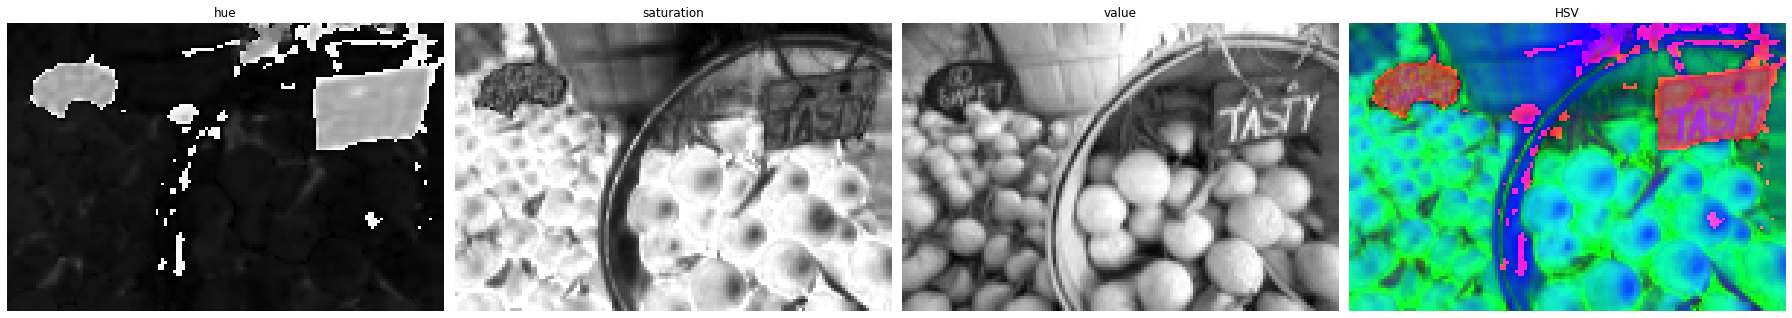

In [0]:
hsvimg = colo.rgb_to_hsv(img)
hsv = ['hue','saturation','value','HSV']
imgplot(hsvimg ,hsv)
chanCorr(hsvimg)

**Explain why there is less correlation now!** If you are not familiar with
the HSV-representation, have a look at Wikipedia: HSL&HSV.

There is less correlation because hue, saturation, and value are designed to avoide the correlations seen in natural scene's RGB components, caused by common light sources. HSV does not suffer from this same curse of correlated components.

3. We will now compute three independent saliency maps for the image using the
HSV-representation. Therefore, decompose the image into the separate HSVchannels. Then, perform the following computations for each channel separately: **For each pixel in the image, extract the surrounding 15 × 15 pixel image patch
(hint: feel free to ignore the edges of the image for which no full patches can be
1
obtained). For each patch compute the standard deviation of the pixel values.**
Note that the Hue-channel (but not the Saturation- or Value-channels) represents
a circular variable (“color circle”), so that computing the ordinary standard deviation (the function std) may result in artifacts. Use circular standard deviation
instead (hint: the function scipy.stats.circstd is of help here, but be sure that
parameter high=1). Store the standard deviation of the patches around each pixel
in a new “saliency image”.

In [0]:
from scipy.stats import circstd
salimg = []

imshap = hsvimg[:,:,0].shape
stridebounds = (imshap[0]-14, imshap[1]-14) # limits of stride
hsvimgs = [hsvimg[:,:,0],hsvimg[:,:,1],hsvimg[:,:,2]]

for i,x in enumerate(hsvimgs):
  stdvals = np.empty(stridebounds)
  for j in range(stridebounds[0]):
    for k in range(stridebounds[1]):
      if i == 0:
        stdvals[j,k] = circstd(x[j:j+15,k:k+15],high=1)
      else:
        stdvals[j,k] = np.std(x[j:j+15,k:k+15])
  salimg.append(stdvals.T)


4. After finishing the previous task, you should have one saliency image for each
image channel at a slightly smaller size than the original picture. **Plot the separate
saliency images into a single figure.**


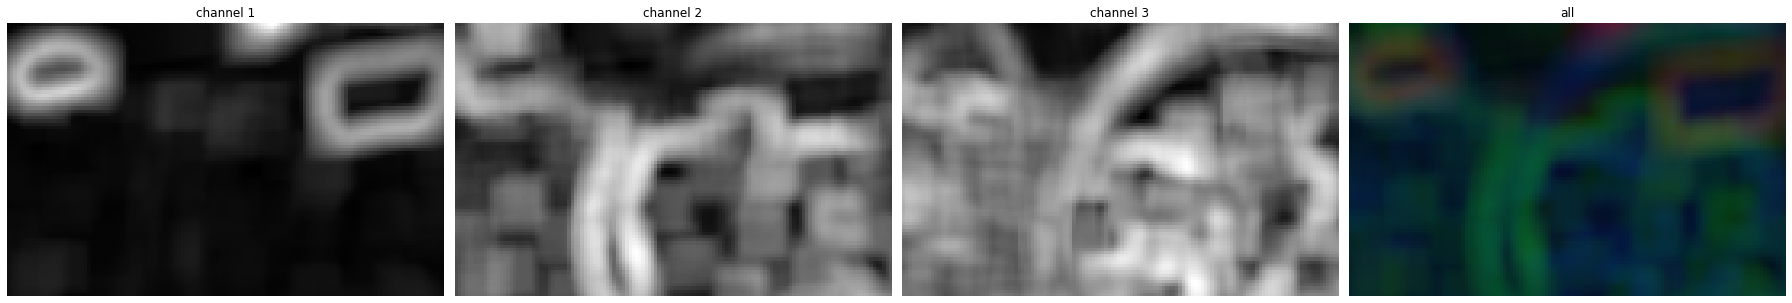

In [0]:
salimg = np.asarray(salimg).T
joint_salimg = np.sum(salimg,axis=2)
sali = ['channel 1','channel 2', 'channel 3','all']
imgplot(salimg,sali)

# f2, ax1 = plt.subplots(1, 1)
# f2.set_figheight(10)
# f2.set_figwidth(6)
# ax1.imshow(np.sum(salimg,axis=2))
# ax1.axis('off')
# ax1.set_title('joint saliency map')
# plt.tight_layout()


**How is each of the three images related to the
visual properties of the image?**

The first saliency map seems to code for wooden signs in the image, the second for the boundaries between oranges and wood, the third for the brightnes of the oranges.

5. **Compute a joint saliency map by summing the separate saliency images you have
computed.** This joint map represents the “attractiveness” of each position in the
image when considering the information in all three image channels. Add this plot
to the previous figure.




Please see above.

6. You will see that the combined saliency image still contains a lot of detail. To
generate a more naturally behaving saliency map, **smooth this image by low-pass
filtering (hint: use scipy.ndimage.gaussian filter. Experiment with different
sigmas and padding modes). Plot the result into a new figure.**

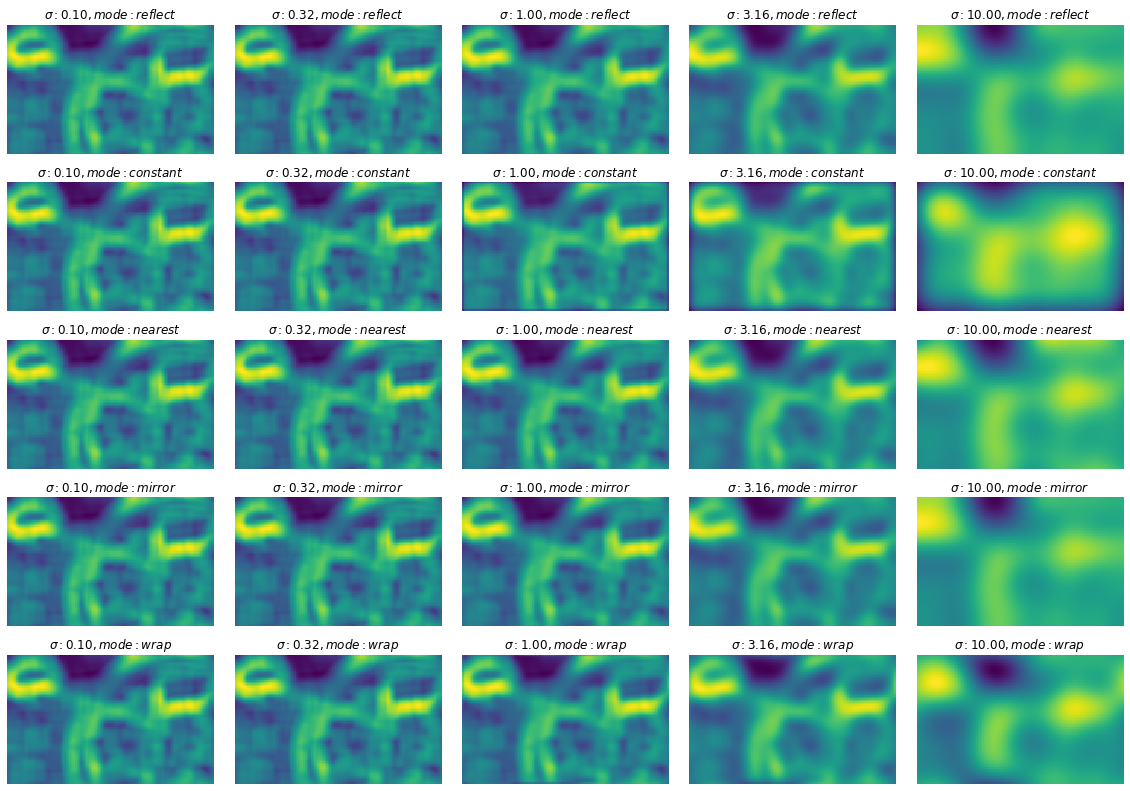

In [0]:
modes = ['reflect', 'constant', 'nearest', 'mirror','wrap']
sigmas = np.logspace(-1,1,5)

fig, axs = plt.subplots(5,5, figsize=(20, 14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

k = -1 # counter
for i,x in enumerate(modes):
  for j,y in enumerate(sigmas):
    k += 1
    axs[k].imshow(ndi.gaussian_filter(joint_salimg,mode=x,sigma=y))
    axs[k].set_title(f'$\sigma:{y:.2f}, mode:{x}$')
    axs[k].axis('off')


7. In a new figure, **plot the original image and overlay the contours of the smoothed
saliency map** (hint: remember that the saliency map is smaller than the original
image. Correct for this and then use the function contour to plot the map upon
the image).


8.  From  the  smoothed  saliency  map,  **extract  the  positions  the  subject  will  mostlikely and least likely look at (hint:  useargmaxandargminin conjunction withunravelindexto locate the indices of those points within the image).  Mark thosepoints with a red and blue dot, respectively (hint:  functionplotwithmarker=’o’works well).**

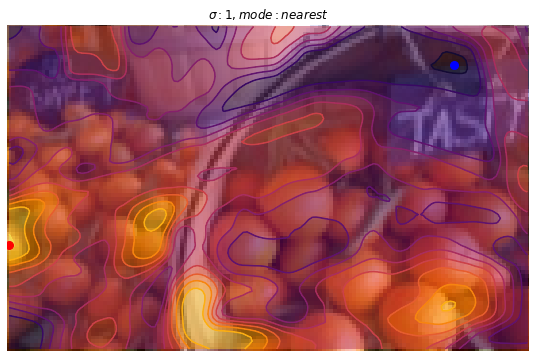

In [0]:
fig, ax0 = plt.subplots(1,1, figsize=(10,6), facecolor='w', edgecolor='k')

mi = np.unravel_index(np.argmin(saliency),stridebounds)
ma = np.unravel_index(np.argmax(saliency),stridebounds)

ax0.imshow(img[7:-7,7:-7,:])
ax0.contourf(saliency,cmap='inferno',levels=10,alpha=.5)
ax0.contour(saliency,cmap='inferno',levels=10)
ax0.plot(mi[1],mi[0],marker='o',c='b',markersize=8)
ax0.plot(ma[1],ma[0],marker='o',c='r',markersize=8)
ax0.set_title(f'$\sigma:1, mode:nearest$')
ax0.axis('off')

plt.show()

**How do you interpret the completed image?**

The image shows areas of high and low salience for humans' visual system. It represent our exogenous attention and what we, deep down inside, are compelled, even driven, instinctually, to see.

9. **Repeat  the  above  procedures  to  plot  a  saliency  map  onto  the  complete  set  of color  images  provided.**  

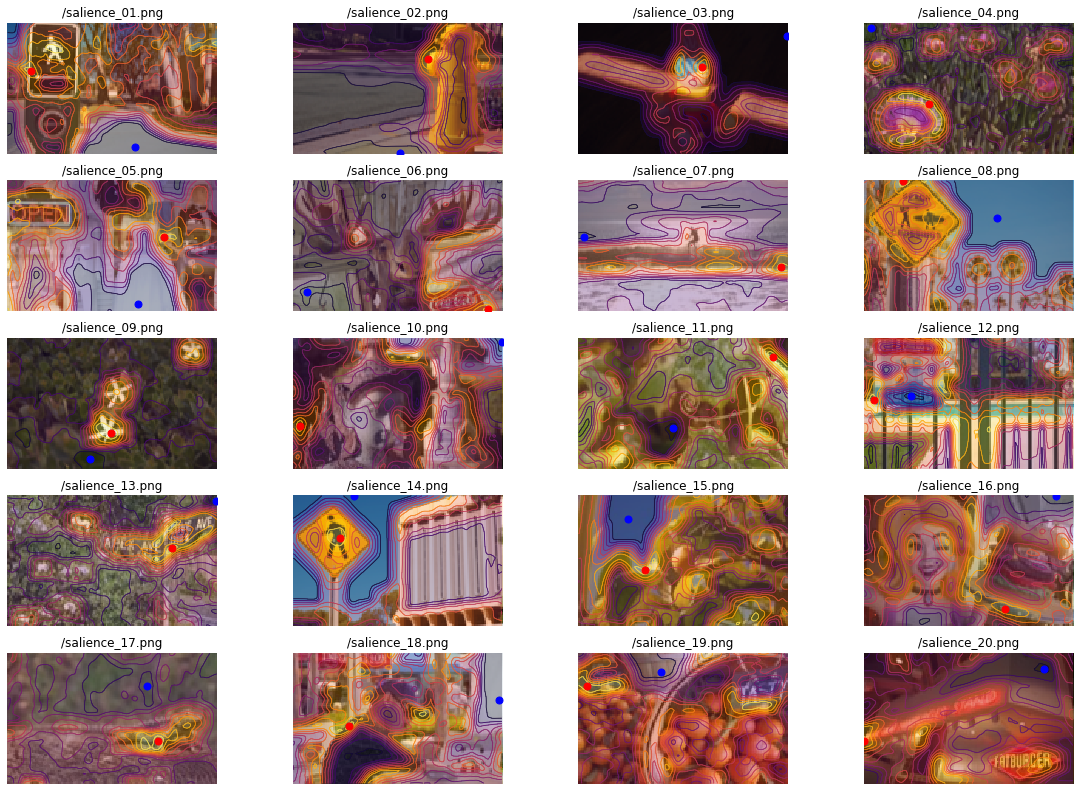

In [0]:
# Setting up figure for plots
fig, axs = plt.subplots(5,4, figsize=(20, 14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

for l,z in enumerate(np.arange(20)):
  # Defining image filename
  if z <= 8: 
    imgn = f'salience/salience_0{l+1}.png'
  else:
    imgn = f'salience/salience_{l+1}.png'

  # Reading in image as HSV
  img = plt.imread(imgn)
  hsvimg = colo.rgb_to_hsv(img)

  # Calculating std over each HSV component
  salimg = []
  imshap = hsvimg[:,:,0].shape
  stridebounds = (imshap[0]-14, imshap[1]-14) # limits of stride
  hsvimgs = [hsvimg[:,:,0],hsvimg[:,:,1],hsvimg[:,:,2]]

  for i,x in enumerate(hsvimgs):
    stdvals = np.empty(stridebounds)
    for j in range(stridebounds[0]):
      for k in range(stridebounds[1]):
        if i == 0:
          stdvals[j,k] = circstd(x[j:j+15,k:k+15],high=1)
        else:
          stdvals[j,k] = np.std(x[j:j+15,k:k+15])
    salimg.append(stdvals.T)

  # Applying Gaussian filter to joint HSV image
  salimg = np.asarray(salimg).T
  joint_salimg = np.sum(salimg,axis=2)
  saliency = ndi.gaussian_filter(joint_salimg,mode='nearest',sigma=1)

  # Defining points of maximum and minimum saliency
  mi = np.unravel_index(np.argmin(saliency),stridebounds)
  ma = np.unravel_index(np.argmax(saliency),stridebounds)
  
  # Plotting saliency maps and images
  axs[l].imshow(img[7:-7,7:-7,:])
  axs[l].contourf(saliency,cmap='inferno',levels=10,alpha=.3)
  axs[l].contour(saliency,cmap='inferno',levels=10,linewidths=.75)
  axs[l].plot(mi[1],mi[0],marker='o',c='b',markersize=7)
  axs[l].plot(ma[1],ma[0],marker='o',c='r',markersize=7)
  axs[l].set_title(f'{imgn}')
  axs[l].axis('off')

**Discuss  possible  shortcomings  of  the  proposed  saliencyalgorithm.  To this end, pick images for which the most salient position according to the algorithm does not conform with your expectation of how human attentionworks.  Name at least two different image features the algorithm does not take intoaccount and illustrate each with a different image**

We see shortcomings in the analysis of images 12 and 18. In 12, we see a point of low saliency on the sign in front of the pool. It seems this dark center, light surround inapporpriately estimates what many humans would look at -- **dark text**. In image 18, we also see the algorithm overlook human salience for **human faces**. Hue, saturation, and value are thus still low level features that cannnot account for higher level perceptual bias.

10. We  know  from  experiments  that  subjects  are  much  more  likely  to  first  attendthe center of an image, instead of the borders.  **Please outline in words how thisinformation could be included in the above saliency-map analysis to better predicteye-movements.**

We incorporate knowlegde of human preference for the center of the image by including a filter over the entire image that weights pixels on the edges of the images as lower. It could be included to reduce salience for areas of the image which are not so important.

**Exercise 2: Mexican-hat convolution (optional/bonus task)**

1. **Decompose the HSV-image into separate channels.  As a preparation for the follow-ing task, generate an array representing a “mexican hat” filter using thehelper-functionmexicanhat with  a  size  of  20x20  pixels  and  a  width  of  3.**   The  filterreturned  from  the  helper  function  is  its  spatial-domain  representation  and  neednot be transformed.

In [0]:
import scipy.signal 

def mexican_hat(x_size,y_size,width):
    '''generate a 2D-mexican hat filter'''
    x_linear=np.arange(-np.floor(x_size/2.0),np.ceil(x_size/2.0))
    y_linear=np.arange(-np.floor(y_size/2.0),np.ceil(y_size/2.0))
    x_grid, y_grid = np.meshgrid(x_linear,y_linear)
    t = np.sqrt(x_grid**2 + y_grid**2)

    mexican = 2.0 / np.sqrt(3.0) / width / np.pi**(1/4) * (1-1/2.0*t**2/width**2) \
            * np.exp(-t**2/2/width**2) 
    return np.real(mexican)

2.  For each image channel repeat the following procedure:  **Convolve the image withthe prepared “mexican hat” filter (hint:  usescipy.signal.convolve2d).  Try outwhat happens with different boundary conditions and explain which one producesthe best result.**  Choose themodeparameter appropriately to get a result that isthe same size as the original image.


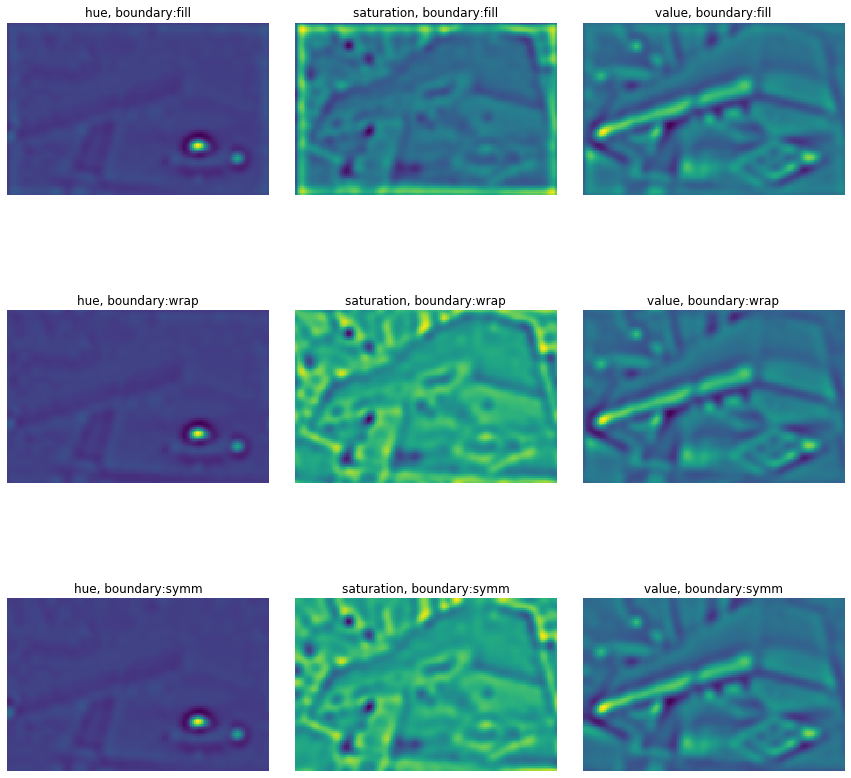

In [0]:
filt = mexican_hat(20,20,3)
boundaries = ['fill','wrap','symm']
meximgs = []
hsvimgs = np.array(hsvimgs)

fig, axs = plt.subplots(3,3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

k = -1 # counter

for j,y in enumerate(boundaries):
  for i in range(3): # for each hue, saturation, value image
    k += 1
    meximg = scipy.signal.convolve2d(hsvimgs[i,:,:],filt,mode='same',boundary=y)
    meximgs.append(meximg)

    axs[k].imshow(meximg)
    axs[k].set_title(f'{hsv[i]}, boundary:{y}')
    axs[k].axis('off')


The fill boundary looks worst, it increases weighting on the edges. It's hard to tell whether symm of warp is better...

3. The resulting convolution image will have negative as well as positive values. **Applythe  absolute  value  function  in  order  to  obtain  a  positive  saliency  map  for  eachchannel.**

In [0]:
meximgs = np.abs(meximgs)

4. **Plot the three resulting saliency maps into a single figure, and also add the com-bined saliency map that you obtain by summation.** 

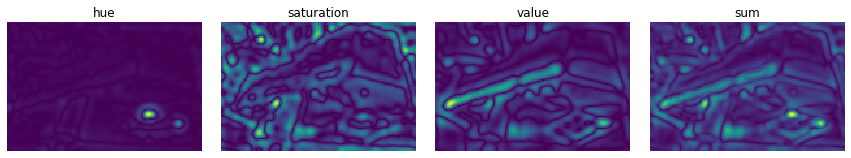

In [0]:
# saliency maps for various boundaries
joint_fmeximg = np.sum(meximgs[0:3],axis=0) # fill
joint_wmeximg = np.sum(meximgs[3:6],axis=0) # wrap
joint_smeximg = np.sum(meximgs[6:9],axis=0) # symm

# contours
fsaliency = ndi.gaussian_filter(joint_fmeximg,mode='nearest',sigma=1)
wsaliency = ndi.gaussian_filter(joint_wmeximg,mode='nearest',sigma=1)
ssaliency = ndi.gaussian_filter(joint_smeximg,mode='nearest',sigma=1)

contours = [fsaliency, wsaliency, ssaliency, saliency]
boundaries = ['fill','wrap','symm','std summation']

# plotting
fig, axs = plt.subplots(1,4, figsize=(15, 7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

for i,x in enumerate(meximgs[3:6]): # wrap
  axs[i].imshow(x)
  axs[i].set_title(hsv[i])
  axs[i].axis('off')

axs[3].imshow(joint_wmeximg)
axs[3].set_title('sum')
axs[3].axis('off')

plt.show()

**In which aspects do the saliencymaps obtained by convolution differ from the saliency maps that you obtained bycomputing standard deviation on image patches.  Can you give an intuition why?**

The convolution saliency maps give smaller, more precise areas of high salience, with much lower salience over the rest of the image. The dip in the mexican hat means the salience is shifted lower for almost all pixels in the image. Perhaps this might better show saccadic movement.

5. **Perform the low-pass filtering and the analysis of attracting and repelling imagepositions as described in exercise 1.**  Plot the obtained saliency contours and com-puted image positions onto the original images and compare the resulting graphswith those of the previous exercise.  Do you think that computing the standarddeviation across patches is a valid shortcut?  What is the disadvantage of using theconvolution technique on HSV-represented images?

The disadvantage of the convolution technique is less precision in the salient areas of the image. It seems to be a valid shortcut for identifying largest salient areas -- those that first stimulate our exogenous attention.

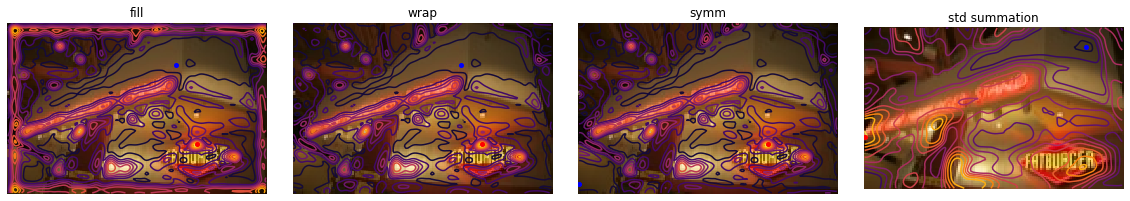

In [0]:
# plotting
fig, axs = plt.subplots(1,4, figsize=(20, 14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

for i,x in enumerate(contours):
  if i == 3:
    axs[i].imshow(img[7:-7,7:-7,:])
  else:
    axs[i].imshow(img)

  mi = np.unravel_index(np.argmin(x),x.shape)
  ma = np.unravel_index(np.argmax(x),x.shape)

  axs[i].set_title(f'{boundaries[i]}')
  axs[i].axis('off')

  # axs[i].contourf(x,cmap='inferno',levels=10,alpha=.5)
  axs[i].contour(x,cmap='inferno',levels=10)
  axs[i].plot(mi[1],mi[0],marker='o',c='b',markersize=4)
  axs[i].plot(ma[1],ma[0],marker='o',c='r',markersize=4)